In [81]:
import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import text, sequence

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize

import pkg_resources
from symspellpy import SymSpell, Verbosity

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [82]:
train = pd.read_csv("train.csv")
train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [83]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [84]:
train['comment_text'][150]

'"\n\n Socialistm? \n\nThere are two important features of Smith\'s concept of the ""invisible hand"". First, Smith was not advocating a social policy (that people should act in their own self interest), but rather was describing an observed economic reality (that people do act in their own interest). Second, Smith was not claiming that all self-interest has beneficial effects on the community. He did not argue that self-interest is always good; he merely argued against the view that self-interest is necessarily bad. It is worth noting that, upon his death, Smith left much of his personal wealth to charity.\n\nGood!  Let\'s all make sure we put forth the idea that Adam Smith was a socialist.  That\'s the wikipedia way!"'

In [85]:
def decontracted(phrase):
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [86]:
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
bigram_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_bigramdictionary_en_243_342.txt")
# term_index is the column of the term and count_index is the
# column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

True

In [87]:
replace_with_space = re.compile('[/(){}\[\]\|,;:-]')
three_plus = re.compile(r"(.)\1{2,}")
replace_symbols = re.compile('[^a-z !?]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = replace_with_space.sub(' ', text) # replace REPLACE_BY_SPACE symbols by space.
    text = three_plus.sub(r"\1\1", text) # replace any chars that appears more than two times in a row with 2 chars
    text = re.sub('\s+', ' ', text) # replace whitespace with space
    text = re.sub('$', 's', text) # replace $ with s
    text = re.sub('@', 'a', text) # replace @ with a
    text = decontracted(text)
    text = replace_symbols.sub('', text) # remove symbols in BAD_SYMBOLS_RE from text.
    suggestions = sym_spell.lookup_compound(text, max_edit_distance=2)
    text = suggestions[0].term # spellcheck
    stop_words = set(stopwords.words("english")) 
    text = word_tokenize(text) 
    text = [word for word in text if word not in stop_words] # remove stop words
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word, pos ='v') for word in text] # lemmatize words
    return text


In [88]:
# fix words returned as seperated by brackets and commas. 
qfix = re.compile('[()\[\],]')
def quick_fix(text):
    text = qfix.sub('',text)

In [89]:
# Single core implementation of text processing
# Do not run long run time
#
# Clean train comment text
# train['comment_text'] = df['comment_text'].apply(clean_text)
# train['comment_text'] = df['comment_text'].apply(qfix)
# df.to_csv('spellcheck.csv', index = False, header=True)
#
# Clean text comment text
# test = pd.read_csv("test.csv")
# test_lab = pd.read_csv("test_labels.csv")
#
# df_test = test.merge(test_lab, on = 'id')
# df_test = df_test[df_test['toxic'] != -1] # remove unlabeded data
# df_test['comment_text'] = df_test['comment_text'].apply(clean_text)
# df_test['comment_text'] = df_test['comment_text'].apply(qfix)
# df.to_csv('spellcheck.csv', index = False, header=True)

In [90]:
# USE PARALLEL COMPUTING HERE
# df = train.loc[120001:130000,:]
# 
# df['comment_text'] = df['comment_text'].apply(clean_text)
#
# df.to_csv('spellcheck13.csv', index = False, header=True)
# train['comment_text'] = train['comment_text'].apply(clean_text)

In [91]:
# load text processed data
train = pd.read_csv('spellcheck.csv')
train = train.replace(np.nan, '', regex=True)
train['comment_text'][150]

'socialist two important feature smith concept invisible hand first smith advocate social policy people act self interest rather describe observe economic reality people act interest second smith claim self interest beneficial effect community argue self interest always good merely argue view self interest necessarily bad worth note upon death smith leave much personal wealth charity good let make sure put forth idea adam smith socialist wikipedia ways'

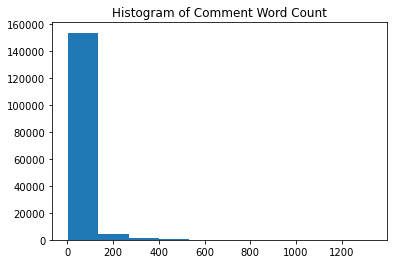

In [92]:
comment_word_count = train['comment_text'].apply(lambda x: len(str(x).split(" ")))
plt.hist(comment_word_count)
plt.title("Histogram of Comment Word Count")
plt.show()

In [93]:
MAX_NB_WORDS = 35000 # number of most frequent words to keep
MAX_SEQUENCE_LENGTH = 200 # number of words to keep per comment

tokenizer = text.Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(train['comment_text'].values)

In [94]:
word_index = tokenizer.word_index
len(word_index) # number of unique tokens

55268

In [95]:
count_list = list(tokenizer.word_counts.items())
len([i for i in range(0,len(count_list)) if count_list[i][1]<3]) # total number of words that appear less than three times

20594

In [96]:
list(word_index.items())[35000][0]

'varus'

In [97]:
train = train.sample(frac=1,random_state=13)

In [98]:
# oversample attempt
train_idhate = train[train['identity_hate'] == 1].sample(n=500,random_state=13)
train_threat = train[train['threat'] == 1].sample(n=300,random_state=13)
train = pd.concat([train, train_idhate])
train = pd.concat([train, train_threat])

In [99]:
train = train.sample(frac=1,random_state=133)
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,160371.000000,160371.000000,160371.000000,160371.000000,160371.000000,160371.000000
mean,0.100037,0.011162,0.056045,0.005082,0.052828,0.012272
std,0.300050,0.105058,0.230009,0.071107,0.223690,0.110096
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [100]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y_train = train[list_classes].to_numpy()
X_train = tokenizer.texts_to_sequences(train["comment_text"].values)
X_train = sequence.pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)

In [101]:
print(X_train.shape,y_train.shape)

(160371, 200) (160371, 6)


In [102]:
embeddings_index = {}
f = open('glove.6B.200d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [103]:
embedding_matrix = np.zeros((len(word_index) + 1, MAX_SEQUENCE_LENGTH))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [104]:
embedding_layer = layers.Embedding(len(word_index) + 1,
                            MAX_SEQUENCE_LENGTH,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH)

In [112]:
EMBEDDING_DIM = 200

model = keras.Sequential()
model.add(embedding_layer)
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.Bidirectional(layers.LSTM(75, return_sequences=True)))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(6, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy','AUC'])

In [113]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 200)          11053800  
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 200, 200)          0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 200, 150)          165600    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 150)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 906       
Total params: 11,220,306
Trainable params: 11,220,306
Non-trainable params: 0
_________________________________________________________________


In [114]:
epochs = 2
batch_size = 50

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, min_delta=0.0001)])

Epoch 1/2
2887/2887 [==============================] - 1929s 666ms/step - loss: 0.0823 - binary_accuracy: 0.9735 - auc: 0.9467 - val_loss: 0.0485 - val_binary_accuracy: 0.9812 - val_auc: 0.9813
Epoch 2/2
2887/2887 [==============================] - 1542s 534ms/step - loss: 0.0428 - binary_accuracy: 0.9832 - auc: 0.9888 - val_loss: 0.0452 - val_binary_accuracy: 0.9823 - val_auc: 0.9855


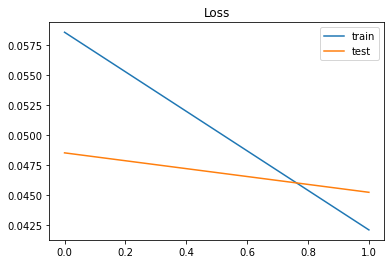

In [115]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

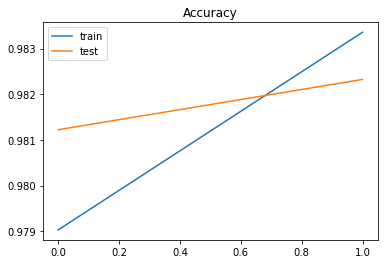

In [116]:
plt.title('Accuracy')
plt.plot(history.history['binary_accuracy'], label='train')
plt.plot(history.history['val_binary_accuracy'], label='test')
plt.legend()
plt.show();

In [130]:
#model.save('my_mod_spellcheck_oversample_glove.h5')

In [24]:
#from keras.models import load_model
#model = load_model('my_mod_spellcheck_oversample_glove.h5')

In [117]:
# read text processed test data
df_test = pd.read_csv("spellchecktest.csv")
df_test = df_test.replace(np.nan, '', regex=True)

In [118]:
df_test

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0001ea8717f6de06,thank understand think highly would revert wit...,0,0,0,0,0,0
1,000247e83dcc1211,dear god site horrible,0,0,0,0,0,0
2,0002f87b16116a7f,somebody invariably try add religion really me...,0,0,0,0,0,0
3,0003e1cccfd5a40a,say right type type institution need case thre...,0,0,0,0,0,0
4,00059ace3e3e9a53,add new product list make sure relevant add ne...,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
63973,fff8f64043129fa2,jerome see never get around surprise look exam...,0,0,0,0,0,0
63974,fff9d70fe0722906,lucky bastard help wikimediafoundationorg wiki...,0,0,0,0,0,0
63975,fffa8a11c4378854,shame want speak gays romanians,0,0,0,0,0,0
63976,fffac2a094c8e0e2,mel gibson nazi bitch make shitty movies much ...,1,0,1,0,1,0


In [119]:
y_test = df_test[list_classes].to_numpy()

In [120]:
X_test = tokenizer.texts_to_sequences(df_test["comment_text"].values)
X_test = sequence.pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)

In [129]:
model.evaluate(X_test,y_test)

2000/2000 [==============================] - 121s 60ms/step - loss: 0.0685 - binary_accuracy: 0.9709 - auc: 0.9812


[0.06853551417589188, 0.9709248542785645, 0.9811541438102722]

In [121]:
# using kaggle scoring

from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, model.predict(X_test))

0.9806049296670137

In [126]:
new_insult = ['fuck off little shit']
new_insult[0] = clean_text(new_insult[0])
new_insult

[['fuck', 'little', 'shit']]

In [127]:
list_classes

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [128]:
seq = tokenizer.texts_to_sequences(new_insult)
padded = sequence.pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
pred

array([[0.99858904, 0.51672804, 0.99506867, 0.00742623, 0.8870046 ,
        0.01697901]], dtype=float32)